In [2]:
import emcee
import numpy as np
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
from scipy.optimize import minimize
import scipy.signal as signal
import sys
from hampel import hampel
import pandas as pd 
import scipy.linalg
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import numexpr as ne
import multiprocessing as mp
from collections import defaultdict
mp.set_start_method('fork')

# Detectings QPOs Using Weighted Wavelet Z-Transform (WWZ)

In this notebook we search for quasi-periodic oscillations (QPOs) in blazar light curves using the method of weighted wavelet Z-transform. The WWZ is a time-frequency analysis method, exploring both the frequency domain and the time domain. This has the advantage of allowing us to detect short-lived periodicity that may not be present for the entire duration of observation. 

The WWZ is defined as the following,
$$Z = \frac{ (N_{\text{eff}}-3)V_y }{ 2(V_x-V_y) }$$

Each term, and how this formula came about is explained best in Foster(1996) but a quick overview is shown below.

Link to Foster(1996) : https://articles.adsabs.harvard.edu//full/1996AJ....112.1709F/0001709.000.html


Wavelet transforms perform a similar function to the Fourier transform, but, in addition to this, they can break signals down into oscillations localized in space and time. However, when applied to unevenly sampled time series, the response of the wavelet transform is often more dependent on irregularities in the number and spacing of available data than on actual changes in the parameters of the signal. Yet by casting the wavelet transform as a projection, we can derive its statistical behavior and devise advantageous rescaled transforms. By treating it as a weighted projection to form the weighted wavelet Z-transform (WWZ), we improve its ability to detect, and especially to quantify, periodic and pseudo-periodic signals.

We perform a weighted projection onto the three trial functions

$$\phi_1(t) = \textbf{1}(t)$$

$$\phi_2(t) = \cos(\omega (t-\tau))$$

$$\phi_3(t) = \sin(\omega (t-\tau))$$

Where we compute the weighted projection by defining the inner product of two function $f(t)$ and $g(t)$ as 
\begin{equation}
\langle f|g \rangle = \frac{\sum_{\alpha=1}^N w_\alpha f(t_\alpha )g(t_\alpha ) }{\sum_{\beta=1}^N w_\beta}
\end{equation}

and with the statistical weights modified to include the inverse variance weights from CHIME, the statistical weight assigned to a data point $\alpha$ is defined as 
\begin{equation}
w_{\alpha} = \frac{1}{\sigma_\alpha^2} \cdot e^{-c\omega^2(t_\alpha - \tau)^2}
\end{equation}

Notice the factor of $\omega$ in the exponential, the size of the “window” is frequency-dependent. The constant $c$ determines how rapidly the window decays. We have chosen $c$ such that 3 periods can fit within the full width at half maximum (FWHM) of the Gaussian window:

$$ e^{-c\omega^2(t-\tau)^2} = e^{\frac{-(t-\tau)^2}{2\sigma^2}}$$
$$c\omega^2 = \frac{1}{2\sigma^2} \implies c \left(\frac{2\pi}{T}\right)^2 = \frac{1}{2\sigma^2}$$
$$c = \frac{T^2}{8\pi^2\sigma^2}$$
If we want the FWHM to contain 3 periods we must have that $2.355\sigma = 3T$.
Therefore $\sigma = \frac{3T}{2.355}$ and Plugging this in we get
$$c = \frac{1}{8\left(\frac{3}{2.355}\right)^2\pi^2} \approx 0.0078$$

Projection computes the coefficients $y_a$ of a set of r trial functions for which the model function:
$$y(t) = \sum_a y_a \phi_a(t),$$
best fits the data (in the sense that it minimizes the sum of the squared residuals).

We then compute the S-matrix, which is the matrix of the inner products of the trial functions
\begin{equation}
S_{ab} = \langle \phi_a|\phi_b \rangle
\end{equation}

We determine the best-fit coefficients of our trial functions by multiplying the inverse of the S-matrix by the vector of inner products of the trial functions with the data

\begin{equation}
y_a = \sum_{b} S_{ab}^{-1} \langle \phi_b|x \rangle
\end{equation}

We define the power (which we use to evaluate the projection statistically) by 
\begin{equation}
P = \frac{N}{(r-1)s^2} \left(\sum_{a,b}S^{-1}_{ab}\langle \phi_a|x \rangle \langle \phi_b|x \rangle - \langle \textbf{1}|x \rangle^2 \right)
\end{equation}

where $N$ is the number, and $s^2$ the estimated variance of the data. 

A modification imposed by a weighted projection is that in the definition of the power we must replace the number of data points N by the effective number:

\begin{equation}
N_{\text{eff}} = \frac{(\Sigma w_\alpha)^2}{(\Sigma w_\alpha^2)}
\end{equation}

and instead use the weighted estimated variance 
\begin{equation}
s_w^2 = \frac{N_{\text{eff}}V_x}{N_{\text{eff}}-1} 
\end{equation}

where $V_x$ is the weighted variation of the data 

\begin{equation}
V_x = \frac{\Sigma_\alpha w_\alpha x^2(t_\alpha)}{\Sigma_\lambda w_\lambda} - \left[\frac{\Sigma_\alpha w_\alpha x(t_\alpha)}{\Sigma_\lambda w_\lambda}\right]^2 = \langle x|x\rangle - \langle \textbf{1}|x \rangle^2
\end{equation}

and similarly, the weighted variation of the model function is 

\begin{equation}
V_y = \frac{\Sigma_\alpha w_\alpha y^2(t_\alpha)}{\Sigma_\lambda w_\lambda} - \left[\frac{\Sigma_\alpha w_\alpha y(t_\alpha)}{\Sigma_\lambda w_\lambda}\right]^2 = \langle y|y\rangle - \langle \textbf{1}|y \rangle^2
\end{equation}

Foster then goes on to define the weighted wavelet transform (WWT) as 
\begin{equation}
WWT = \frac{ (N_{\text{eff}}-1)V_y }{ 2V_x }
\end{equation}

For fixed parameters $\omega$ and $\tau$, the WWT may be treated as a chi-square statistic with two degrees of freedom and expected value 1.


The above expected values for the WWT only hold when the data is random noise. For a sinusoidal signal, one might expect the WWT to peak at the signal frequency, but instead it tends to peak at a lower frequency, due to an effect which strongly impacts the WWT. At lower frequencies, our “window” is wider, so we effectively sample more data points; the effective number $N_{\text{eff}}$ is larger. This can make the WWT increase with decreasing $\omega$, even though the fit to the data is poorer, simply because the factor $N_{\text{eff}}$ is larger. 

We would get a better estimate of the frequency of a significant peak if we had a test statistic which was less sensitive to the effective number of data. Fortunately, there is such a statistic for projections: Foster applies the Z-statistic of Foster (1996a) which he dubs the weighted wavelet Z-transform (WWZ):

\begin{equation}
Z = \frac{ (N_{\text{eff}}-3)V_y }{ 2(V_x-V_y) }
\end{equation}

In [3]:
# https://articles.adsabs.harvard.edu//full/1996AJ....112.1709F/0001709.000.html

# Eq. 5.3, but with optional noise weights included
def wa(omega,tau,t,c=0.0125,weights=None):
    wavelet = np.exp(-1*c*(omega[:,np.newaxis,np.newaxis]
                           *(t[np.newaxis,np.newaxis,:]-tau[np.newaxis,:,np.newaxis]))**2)
    if weights is not None:
        wavelet *= weights
    return wavelet

# Eq. 5.4
def Neff(omega,tau,t,c=0.0125,weights=None):
    weight = wa(omega,tau,t,c=c,weights=weights)
    return np.square(np.sum(weight,axis=-1)) / np.sum(np.square(weight),axis=-1)

# Eq. 5.5-5.7
def phi(n,omega,tau,t):
    if n==0:
        return np.ones((len(omega),len(tau),len(t)))
    if n==1:
        return np.cos(omega[:,np.newaxis,np.newaxis]
                      *(t[np.newaxis,np.newaxis,:]-tau[np.newaxis,:,np.newaxis]))
    if n==2:
        return np.sin(omega[:,np.newaxis,np.newaxis]
                      *(t[np.newaxis,np.newaxis,:]-tau[np.newaxis,:,np.newaxis]))
    
def make_phi(omega,tau,t):
    phi0 = np.ones((len(omega),len(tau),len(t)))
    phi1 = np.cos(omega[:,np.newaxis,np.newaxis]*(t[np.newaxis,np.newaxis,:]-tau[np.newaxis,:,np.newaxis]))
    phi2 = np.sin(omega[:,np.newaxis,np.newaxis]*(t[np.newaxis,np.newaxis,:]-tau[np.newaxis,:,np.newaxis]))
    return np.array([phi0,phi1,phi2])

# Eq. 4.2
def inner(f,g,omega,tau,t,weight,c=0.0125,weights=None):
    tensor = ne.evaluate('weight*f*g')
    return np.sum(tensor,axis=-1) / np.sum(weight,axis=-1)

    
# Eq. 4.3
def S_inv(omega,tau,t,weight,phi_array,c=0.0125,weights=None):
    Sij = np.ones((len(omega),len(tau),3,3))
    for i in range(3):
        for j in range(3):
            Sij[...,i,j] = inner(phi_array[i],phi_array[j],omega,tau,t,weight,c=c,weights=weights)
    Sinv = np.linalg.inv(Sij)
    return Sinv


def y(x,omega,tau,t,Sinv,weight,phi_array,c=0.0125,weights=None):
    # returns matrix with shape (omega,tau,t)
    yij = np.ones((len(omega),len(tau),3,3))
    for i in range(3):
        for j in range(3):
            yij[...,i,j] = Sinv[...,i,j] * inner(phi_array[j],x,omega,tau,t,weight,c=c,weights=weights)
    # Eq. 4.4
    yi = np.sum(yij,axis=-1)
    # Eq. 4.1
    yt = np.zeros((len(omega),len(tau),len(t)))
    for i in range(3):
        yt += yi[...,i][...,np.newaxis] * phi_array[i]
    return yt

# Eq. 5.9/10
def weighted_variation(x,omega,tau,t,weight,c=0.0125,weights=None):
    # returns matrix with shape (omega, tau)
    xx = inner(x,x,omega,tau,t,weight,c=c,weights=weights)
    x1 = inner(1,x,omega,tau,t,weight,c=c,weights=weights)
    #return xx-x1**2
    return ne.evaluate('xx-x1**2')
        
# Eq. 5.12
def Z(x,omega,tau,t,Sinv,N,weight,phi_array,c=0.0125,weights=None):
    Vx = weighted_variation(x,omega,tau,t,weight,c=c,weights=weights)
    Vy = weighted_variation(y(x,omega,tau,t,Sinv,weight,phi_array,c=c,weights=weights),omega,tau,t,weight,c=c,weights=weights)
    N[N<3] = 3 #Stops WWZ from going negative for some sources
    return ne.evaluate('(N-3) * Vy / (2 * (Vx-Vy))')

#Eq. 5.14
def A(x,omega,tau,t,c=0.0125,weights=None):
    # returns matrix with shape (omega,tau)
    yij = np.ones((len(omega),len(tau),3,3))
    weight = wa(omega,tau,t,c=c,weights=weights)
    Sinv = np.linalg.inv(S(omega,tau,t,c=c,weights=weights))
    for i in range(3):
        for j in range(3):
            yij[...,i,j] = Sinv[...,i,j] * inner(phi(j,omega,tau,t),x,omega,tau,t,c=c,weights=weights)
    # Eq. 4.4
    yi = np.sum(yij,axis=-1)
    y2 = yi[...,1][...]
    y3 = yi[...,2][...]
    return np.sqrt(np.square(y2)+np.square(y3))

For this analysis I have been using a dataset of 1847 blazars observed by CHIME. I have the flux, error, and days saved in seperate files which I load in. I then use a sliding median filter to remove outliers and normalize the light curve such that it's mean is 0 and standard deviation is 1.

In [104]:
all_flux = np.loadtxt('all_flux.txt', delimiter=',') #The flux for each day for each source
all_error = np.loadtxt('all_error.txt', delimiter=',') #The inverse-variance error for each day for each source
all_days = np.loadtxt('all_days.txt', delimiter=',') #All CHIME days with data present
source_list = np.loadtxt('source_data/source_list',delimiter=',', dtype = str)#Gives me the names of the blazars
all_dec = np.loadtxt('all_dec.txt')

#Load a source, input is source_id, output is days, flux, and error
def load_source(source_id,normalized = True):
    days = all_days
    flux = all_flux[:,source_id]
    error = all_error[:,source_id]
    days = days
    good_days = np.where(flux!=0)[0]
    nan_days = np.where(np.isnan(flux[good_days])==True)[0]
    good_days = np.delete(good_days, nan_days)
    flux = flux[good_days]
    error = error[good_days]
    days = days[good_days]
    if normalized:
        flux = (flux - np.mean(flux)) / np.std(flux)
    return days, flux, error

#Uses Hampel filter to remove otliers
def remove_outliers(source_id):
    days, flux, error = load_source(source_id,normalized = False)
    ts = pd.Series(flux)
    window=20
    outlier_indices = hampel(ts, window_size=window, n=3) #Median test
    filtered_days = np.delete(days,outlier_indices) 
    filtered_flux = np.delete(flux,outlier_indices)
    filtered_error = np.delete(error,outlier_indices)
    days_conversion = [np.any(all_days[i]==days[outlier_indices].astype(int)) for i in range(len(all_days))]
    bad_days_indices = np.where(days_conversion)[0]
    filtered_flux =( filtered_flux - np.mean(filtered_flux)) / np.std(filtered_flux) #normalize
    return filtered_days, filtered_flux, filtered_error

#Lomb-Scargle Periodogram for comparison with WWZ
def SNR_periodogram(days, flux,period_range=[4,200]):
    y = flux
    x = days
    periods = np.linspace(period_range[0],period_range[1],period_range[1]-period_range[0]+1)
    ls = np.zeros_like(periods)
    for i, T in enumerate(periods):
        f = 1/T
        M = np.vstack((np.ones_like(x), np.sin(2*np.pi*f*x), np.cos(2*np.pi*f*x))).T
        beta = np.linalg.lstsq(M, y, rcond=None)[0]
        theta1, theta2 = beta[1], beta[2]
        a = np.sqrt(theta1**2 + theta2**2)
        sigma = np.std(np.dot(M,beta) - y)
        SNR = a**2 / (2*sigma**2)
        ls[i] = SNR
    return periods, ls

#If within the first/last 15 data points there are some seperated by a gap, I cut off the data before/after the gap
#This is to fix an issue with the WWZ
def fix(days,flux,error,check=15):
    if np.any(np.diff(days[:check]) > 30):
        cutoff = np.where(np.diff(days[:check])>30)[0][0]+1
        days = days[cutoff:]
        flux = flux[cutoff:]
        error = error[cutoff:]
    last = len(days) - check
    if np.any(np.diff(days[last:]) > 30):
        cutoff = len(days)-(check-np.where(np.diff(days[last:])>30)[0][0])+1
        days = days[:cutoff]
        flux = flux[:cutoff]
        error = error[:cutoff]
    return days, flux, error

In [5]:
#This function plots the WWZ of a specific source
def plot_wwz(days,flux,error=None,c=0.0125,tau_step=10,period_range=(4,200),title="WWZ"):

    
    weights = 1/np.square(error) if np.all(error != None) else None
    tau = days[::tau_step]
    T = np.linspace(period_range[0],period_range[1],period_range[1]-period_range[0]+1)
    omega = np.array([2*np.pi/T[ii] for ii in range(len(T))])

    w = wa(omega,tau,days,c=c,weights=weights)
    phi_array =  make_phi(omega,tau,days)
    Sinv = S_inv(omega,tau,days,w,phi_array,c=c,weights=weights)
    N = Neff(omega,tau,days,c=c,weights=weights)
    wwz = Z(flux,omega,tau,days,Sinv,N,w,phi_array,c=c,weights=weights)

    fig = plt.figure()
    gs = fig.add_gridspec(2, 2,wspace=0.0,hspace=0.0,width_ratios=[1, 3.6],height_ratios=[1, 3.6])
    ((ax3,ax4),(ax1, ax2)) = gs.subplots(sharex="col", sharey=False)
    fig.delaxes(ax3)
    fig.set_figheight(12)
    fig.set_figwidth(14)
    plt.set_cmap('cividis')
    cm = ax2.pcolormesh(tau,2*np.pi/omega,wwz,shading='gouraud')
    ax2.set_xlabel("Time (Days)",fontsize=15)
    ax2.tick_params(axis='x', labelsize=15)
    ax2.tick_params(axis='y', labelsize=15)
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    cax = plt.axes([0.82, 0.15, 0.02, 0.5])
    cbar = plt.colorbar(cm,cax=cax,shrink=0.5)
    ax2.set_yticklabels([])
    #cbar.set_label('Power', rotation=270,fontsize=15,labelpad=15)

    periods, power = SNR_periodogram(days,flux,period_range=period_range)
    ax1.plot(power,periods)
    ax1.grid()
    ax1.set_title(f"L-S",fontsize=18)
    ax1.set_xlabel("Power",fontsize=15)
    ax1.set_ylabel("Period (Days)",fontsize=15)
    ax1.tick_params(axis='x', labelsize=15)
    ax1.tick_params(axis='y', labelsize=15)
    ax1.set_ylim(min(periods),max(periods))

    ax4.set_title(title, fontsize=17,wrap=True)
    ax4.errorbar(days,flux,yerr=error,fmt='.')
    ax4.tick_params(axis='y', labelsize=15)
    ax4.set_ylabel("Flux",fontsize=17)
    ax4.grid()
    ax4.set_xlim(min(tau),max(tau))
    plt.show()
    return wwz

The two plots below show some of the benefits of the WWZ over the Lomb-Scargle periodogram. It can detect signals with varying frequencies and also transient periodic signals.

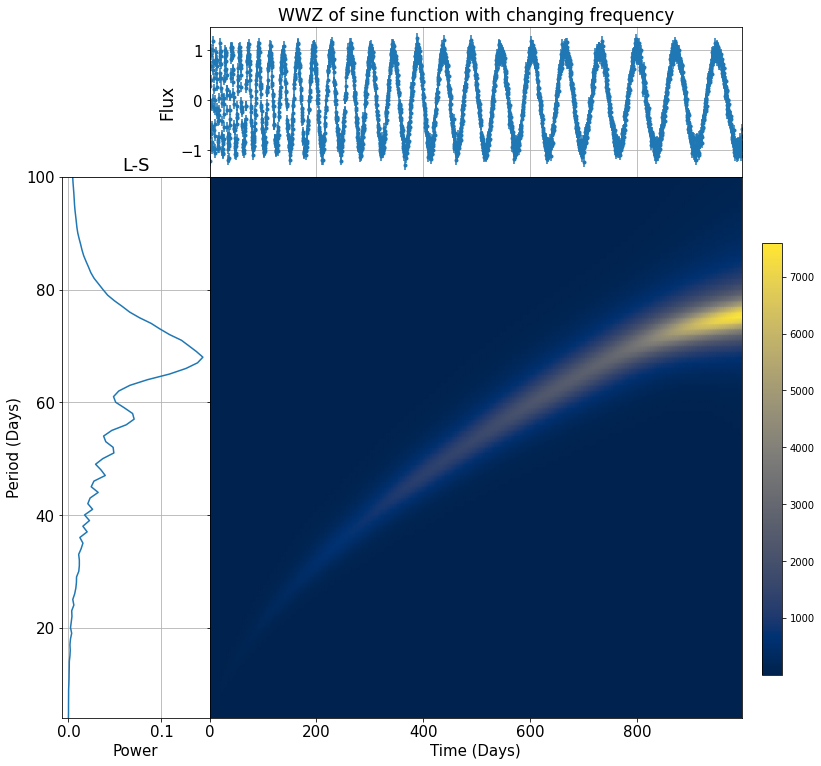

In [6]:
t = np.linspace(0,1000,3000)
x = np.sin(2*np.pi/(1+(t/2)**(4/7))*t)
x += 0.1*np.random.randn(len(x))
xerr = 0.1*np.ones_like(x)
wwz = plot_wwz(t,x,xerr,period_range=(4,100),title=f"WWZ of sine function with changing frequency",c=1/(8*(1.27389**2)*np.pi**2))

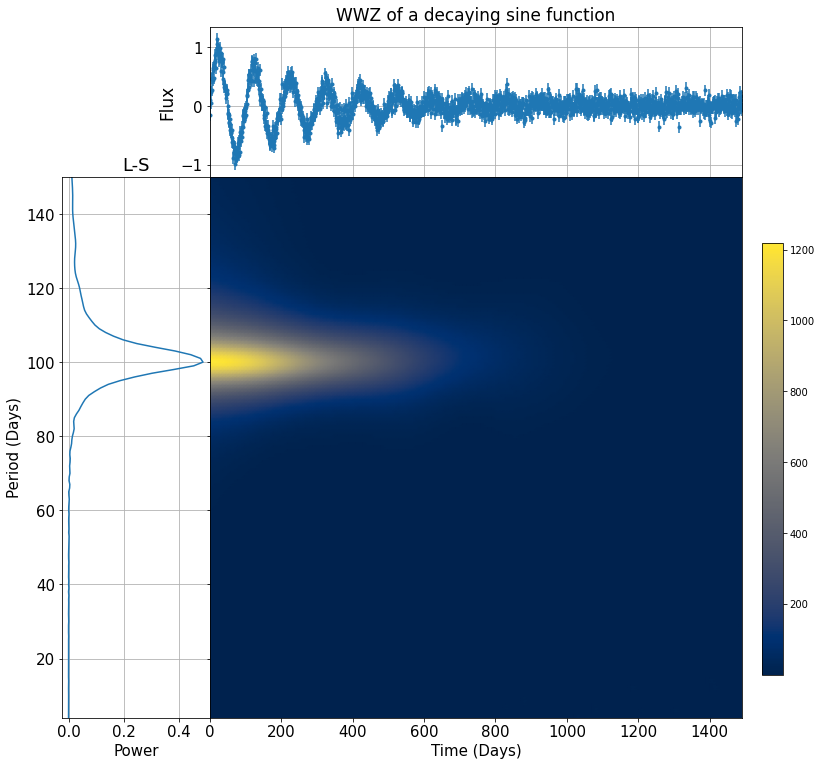

In [7]:
t = np.linspace(0,1500,1500)
x = np.exp(-t/300) * np.sin(2*np.pi/100*t)
x += 0.1*np.random.randn(len(x))
xerr = 0.1*np.ones_like(x)
wwz = plot_wwz(t,x,xerr,period_range=(4,150),title=f"WWZ of a decaying sine function",c=1/(8*(1.27389**2)*np.pi**2))

In [8]:
def plot_wwz(days,flux,error=None,c=0.0125,tau_step=10,period_range=(4,200),title="WWZ"):
    weights = 1/np.square(error) if np.all(error != None) else None
    tau = days[::tau_step]
    T = np.linspace(period_range[0],period_range[1],period_range[1]-period_range[0]+1)
    omega = np.array([2*np.pi/T[ii] for ii in range(len(T))])

    w = wa(omega,tau,days,c=c,weights=weights)
    phi_array =  make_phi(omega,tau,days)
    Sinv = S_inv(omega,tau,days,w,phi_array,c=c,weights=weights)
    N = Neff(omega,tau,days,c=c,weights=weights)
    wwz = Z(flux,omega,tau,days,Sinv,N,w,phi_array,c=c,weights=weights)

    fig = plt.figure()
    gs = fig.add_gridspec(2, 2,wspace=0.0,hspace=0.0,width_ratios=[1, 3.6],height_ratios=[1, 3.6])
    ((ax3,ax4),(ax1, ax2)) = gs.subplots(sharex="col", sharey=False)
    fig.delaxes(ax3)
    fig.set_figheight(12)
    fig.set_figwidth(14)
    plt.set_cmap('cividis')
    cm = ax2.pcolormesh(tau,2*np.pi/omega,wwz,shading='gouraud')
    ax2.set_xlabel("Time (Days)",fontsize=15)
    ax2.tick_params(axis='x', labelsize=15)
    ax2.tick_params(axis='y', labelsize=15)
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    cax = plt.axes([0.82, 0.15, 0.02, 0.5])
    cbar = plt.colorbar(cm,cax=cax,shrink=0.5)
    ax2.set_yticklabels([])
    #cbar.set_label('Power', rotation=270,fontsize=15,labelpad=15)

    periods, power = SNR_periodogram(days,flux,period_range=period_range)
    ax1.plot(power,periods)
    
    
    ax1_2=ax1.twiny()
    ax1_2.plot([max(wwz[i,:]) for i in range(len(omega))],periods,color='tab:orange')
    ax1_2.tick_params(axis='x', labelsize=15)
    ax1.grid()
    ax1.set_title(f"L-S",fontsize=18)
    ax1.set_xlabel("Power",fontsize=15)
    ax1.set_ylabel("Period (Days)",fontsize=15)
    ax1.tick_params(axis='x', labelsize=15)
    ax1.tick_params(axis='y', labelsize=15)
    ax1.set_ylim(min(periods),max(periods))

    ax4.set_title(title, fontsize=17,wrap=True)
    ax4.errorbar(days,flux,yerr=error,fmt='.')
    ax4.tick_params(axis='y', labelsize=15)
    ax4.set_ylabel("Flux",fontsize=17)
    ax4.grid()
    ax4.set_xlim(min(tau),max(tau))
    plt.show()
    return wwz
#TEMP CELL

def window(t,c,omega,tau):
    np.exp(-c*omega**2*(t-tau)**2)

Now, let us plot the WWZ for a real source observed by CHIME. Notice the increase in power towards the second half of the lightcurve, where the periodic signal appears stronger. It is not a coincidence that the peak in power is right at a period of 365 days. This occurs for many sources, due to some seasonal effects on CHIME. Due to this, for the actual analysis we focus on periods shorter than 100 days. Because CHIME observes all 1847 blazars every day, shorter time-scale variation is where CHIME is strong anyway.

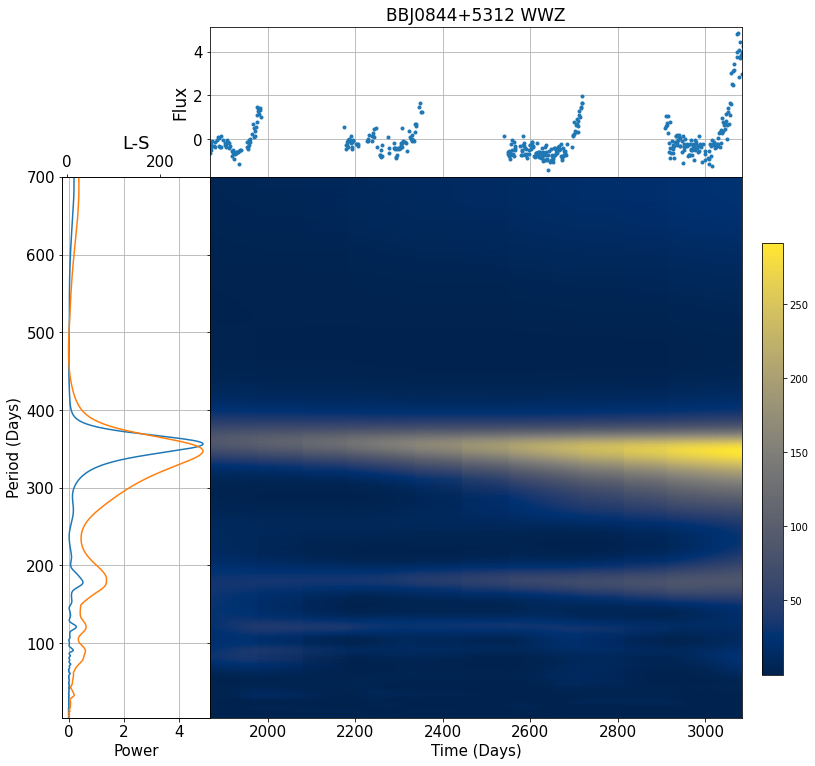

In [9]:
source_id = 625
source_name = source_list[source_id]
days, flux, error = remove_outliers(source_id)
days, flux, error = fix(days,flux,error)
wwz = plot_wwz(days,flux,error,period_range=(4,700),title=f"{source_name} WWZ",c=1/(8*(1.27389**2)*np.pi**2))

Blazar variability, in general, exhibits red-noise-like behavior. This stochaistic variation can sometimes be misidentified as quasi-periodic oscillations (QPOs). Therefore, for a rigorous estimation of the QPO features, we must compare the WWZ of our blazar lightcurves with purely stochastic simulated lightcurves. For this project, blazar light curves are modelled as a continuous time first-order autoregressive process (CAR(1)), which are commonly used to model AGN stochastic variability. A CAR(1) process exhibits the Markov property, which implies that the next data point in
the stochastic light curve depends solely on the present data point and not on any preceding
values. In other words, the modelling of the stochastic light curve is based on a Markovian
assumption, whereby each data point is conditionally independent of all prior data points given
the present data point. We can therefore express the conditional expected value of $Y(t)$ given
$Y(s)$ for $s < t$ as 

\begin{equation}
E(Y(t)|Y(s)) = e^{-\Delta t/\tau}Y(s)+q(1-e^{-\Delta t/\tau}),
\end{equation}
and the conditional variance in $Y(t)$ given $Y(s)$ is given by
\begin{equation}
\text{Var}(Y(t)|Y(s)) = \frac{\tau\sigma^2}{2}(1-e^{-2\Delta t/\tau}),
\end{equation}
where $\Delta t = t-s$, $\sigma$ is the variation amplitude at long
timescale, and $\tau$ is the characteristic damping timescale, and $q$ is the mean value of the light-curve.

By using this model with values of $\sigma$ and $\tau$ that are consistent with our original data, we can generate full light curves with the same variation amplitude and timescale as the blazar we are observing. 
In the next section, we will estimate these parameters from real light curves collected by CHIME.

We use the following likelihood function to model a CAR(1) process,
\begin{equation}
p(y_1,...,y_n |\sigma,\tau,q) = \prod_{i=1}^{n}[2\pi(\Omega_i+\sigma^2)]^{-\frac{1}{2}} \times \exp{\left[-\frac{1}{2}\frac{(\hat{y_i}-y^*_i)^2}{\Omega_i+\sigma^2_i}\right]},
\label{eqn:likelihood}
\end{equation}
where $$y^*_i = y_i - q,$$ $$\hat{y_i} = e^{-(t_i -t_{i-1})/\tau}\hat{y}_{i-1} + \frac{e^{-(t_i -t_{i-1})/\tau}\Omega_{i-1}}{\Omega_{i-1}+\sigma^2_{i-1}}(y^*_{i-1}-\hat{y}_{i-1}),$$ and $$\Omega_i = \Omega_1(1-e^{-2(t_i -t_{i-1})/\tau})+e^{-2(t_i -t_{i-1})/\tau}\Omega_{i-1}\left(1-\frac{\Omega_{i-1}}{\Omega_{i-1}+\sigma^2_{i-1}}\right).$$ The initial values are $\Omega_1 = \frac{\tau \sigma^2}{2}$ and $\hat{x}_1 = 0.$

We set a uniform prior for the logarithm of the parameters $\sigma$ and $\tau$ and a uniform prior for q and normalize our light curve by subtracting the mean and dividing by the standard deviation. We then apply the Markov Chain Monte Carlo (MCMC) sampler $\texttt{emcee}$ with 36 walkers and 5000 iterations to create histograms for each of the three parameters. In order to simulate a light curve with the same characteristics as the observed data from CHIME, we simply have to draw from the sample distributions of each parameter and construct the light curve using the process described in the previous cell.

In [10]:
def simulate(theta, days, error):
    # We simulate the lightcurve as uniformly sampled, then mask it the same as our data
    time = np.linspace(days[0], days[-1], 1 + int(days[-1] - days[0]))
    day_indices = np.where(np.isin(time, days))
    delta_t = 1
    sigma, tau, q = theta
    y = np.empty(len(time))
    y[0] = q  # initial value is mean
    # using equations from Brockwell & Davis
    for i in range(len(time)-1):
        mean = np.exp(-delta_t / tau) * y[i] + q * (1 - np.exp(-delta_t / tau))
        sd = np.sqrt((tau * sigma ** 2) / 2 * (1 - np.exp(-2 * delta_t / tau)))
        y[i + 1] = np.random.normal(loc=mean, scale=sd)
    y = y[day_indices]
    time = time[day_indices]
    return time, y, error

#Defining probability distributions for MCMC
def log_prior(theta):
    log_sigma, log_tau, q = theta
    if -10 < log_sigma < 10 and 0 < log_tau < 10 and -100 < q < 100:
        return 0.0
    return -np.inf

def log_likelihood(theta,time,y,yerr):
    log_sigma, log_tau, q = theta
    sigma = np.exp(log_sigma)
    tau = np.exp(log_tau)
    y_star = y - q
    y_hat = np.zeros_like(y)
    Omega = np.zeros_like(y)
    a = np.exp(-np.diff(time)/tau)
    a = np.insert(a, 0, 0)  # Add a zero at the end to match the size of y_hat and Omega
    Omega[0] = (tau * sigma**2)/2
    Omega[1:] = Omega[0]*(1-a[1:]**2) + a[1:]**2 * Omega[1:] * (1 - Omega[1:]/(Omega[1:]+yerr[1:]**2))
    y_hat[1:] = a[1:] * y_hat[:-1] + a[1:] * Omega[:-1]/(Omega[:-1]+yerr[:-1]**2) * (y_star[:-1]-y_hat[:-1])
    return -0.5 * np.sum(np.log(2 * np.pi * (Omega+yerr**2))) - 0.5 * np.sum( (y_hat - y_star)**2 / (Omega + yerr**2) )

def log_posterior(theta,time,y,yerr):
    return log_prior(theta) + log_likelihood(theta,time,y,yerr)


For each source we simulate 10000 lightcurves, and apply the same sampling as the original lightcurve to them. Then for each period on the WWZ, we compare the power reached by the original WWZ at any time, to the maximum power reached by the simulated lightcurve's WWZ at any time.

In order to find significant periodic candidates we must simulate ~100000 lightcurves for each source. For we source we are testing 100 different periods
$$1847\cdot100 = 184700$$
$$184700\cdot\frac{1}{100000} \approx 1.85$$
Meaning we should expect around 1 or 2 false alarms. If more than 2 individual periods are identified, then they are significant at face value using Gaussian statistics and
should therefore be studied further. Below is the test I run every source through.

In [11]:
def significance_test(source_id, num_sim=100000, c=1/(8*(1.27389**2)*np.pi**2)):
    days, flux, error = remove_outliers(source_id)
    days, flux, error = fix(days, flux, error, check=15)

    weights = 1/np.square(error)
    tau = days[::10]
    T = np.linspace(4, 100, 97)
    omega = np.array([2*np.pi/T[ii] for ii in range(len(T))])
    w = wa(omega, tau, days, c=c, weights=weights)
    phi_array = make_phi(omega, tau, days)
    Sinv = S_inv(omega, tau, days, w, phi_array, c=c, weights=weights)
    N = Neff(omega, tau, days, c=c, weights=weights)
    wwz = Z(flux, omega, tau, days, Sinv, N,
            w, phi_array, c=c, weights=weights)

    ############################ MCMC ############################
    nwalkers = 36
    ndim = 3
    steps = 5000

    # Creates a grid with different starting values of sigma and tau that span across parameter space.
    lnt = np.linspace(0, 5, 6)
    lns = np.linspace(-5, 5, 6)
    xv, yv = np.meshgrid(lns, lnt)
    pos = np.zeros((36, 3))
    pos[:, 0] = xv.reshape(-1)
    pos[:, 1] = yv.reshape(-1)
    # Did this so that all of the q walkers dont start at 0 exactly.
    pos = pos + 1e-4 * np.random.randn(nwalkers, ndim)

    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_posterior, args=(days, flux, error))
    sampler.run_mcmc(pos, steps, progress=False)

    flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

    ############################ Simulation ############################
    all_simulations = list()
    for i in range(num_sim):
        sigma_rand, tau_rand, q_rand = random_param(flat_samples)
        theta = [sigma_rand, tau_rand, q_rand]
        time, x, error = simulate(theta, days, error)
        single_sim = Z(x, omega, tau, time, Sinv, N, w,
                       phi_array, c=c, weights=weights)
        all_simulations.append(single_sim)
    all_simulations = np.array(all_simulations)

    sig_periods = list()
    for i in range(len(omega)):
        if np.any(wwz[i, :] > max(all_simulations[:, i, :].flatten())):
            sig_periods.append(T[i])
    return sorted(sig_periods)

In [12]:
sig_periods = np.load('sig_test_max_periods_100000.npy',allow_pickle=True)

In [13]:
sig_sources = list()
for i in range(len(sig_periods)):
    if sig_periods[i]:
        sig_sources.append(i)
print(sig_sources)


[518, 660, 864, 878, 1268, 1762]


The above test identifies 6 sources as significant, with the requirement that two adjacent periods must be significant in order for a source to be flagged.

In order to run this test, with this many simulations, I made use of the Message Passing Interface (MPI) on Cedar. Specifically, I used the mpi4py.futures package. This package provides a high-level interface for asynchronously executing callables on a pool of worker processes using MPI for inter-process communication. With this Jupyter Notebook I will attach the python and bash scripts I used to execute the tests.

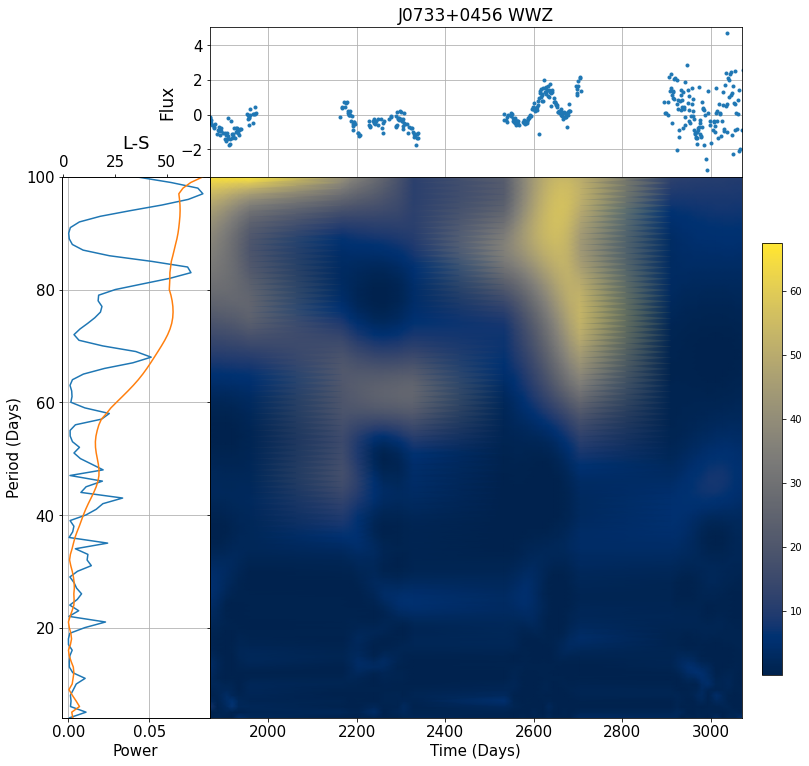

In [14]:
source_id = 518
source_name = source_list[source_id]
days, flux, error = remove_outliers(source_id)
days, flux, error = fix(days,flux,error)
wwz = plot_wwz(days,flux,error,period_range=(4,100),title=f"{source_name} WWZ",c=1/(8*(1.27389**2)*np.pi**2))

# Ringmap Analysis

In order to determine whether or not the periodic signal detected is characteristic of the source itself or if it is coming from something in the background, we can look at the ringmap. I take the average of a circle of points in the sky and compute the WWZ for it to check if the signal detected previously is present.

In [15]:
all_flux_ringmap = np.load('ringmap_flux_518.npy',allow_pickle=True)
all_error_ringmap = np.load('ringmap_error_518.npy',allow_pickle=True)
ra = np.load('ringmap_ra_518.npy',allow_pickle=True)
dec = np.load('ringmap_dec_518.npy',allow_pickle=True)

def load_ringmap(ra_idx,dec_idx,normalized = True):
    days = all_days
    flux = all_flux_ringmap[:,ra_idx,dec_idx]
    error = all_error_ringmap[:,ra_idx]
    good_days = np.where(flux!=0)[0]
    nan_days = np.where(np.isnan(flux[good_days])==True)[0]
    good_days = np.delete(good_days, nan_days)
    flux = flux[good_days]
    error = error[good_days]
    days = days[good_days]
    if normalized:
        flux = (flux - np.mean(flux)) / np.std(flux)
    return days, flux, error

def remove_outliers_ringmap(ra_idx,dec_idx):
    days, flux, error = load_ringmap(ra_idx,dec_idx,normalized = False)
    ts = pd.Series(flux)
    window=20
    outlier_indices = hampel(ts, window_size=window, n=3) #Median test
    filtered_days = np.delete(days,outlier_indices) 
    filtered_flux = np.delete(flux,outlier_indices)
    filtered_error = np.delete(error,outlier_indices)
    days_conversion = [np.any(all_days[i]==days[outlier_indices].astype(int)) for i in range(len(all_days))]
    bad_days_indices = np.where(days_conversion)[0]
    filtered_flux =( filtered_flux - np.mean(filtered_flux)) / np.std(filtered_flux) #normalize
    return filtered_days, filtered_flux, filtered_error

def flatten(matrix):
    flat_list = []
    for row in matrix:
        flat_list += row
    return flat_list

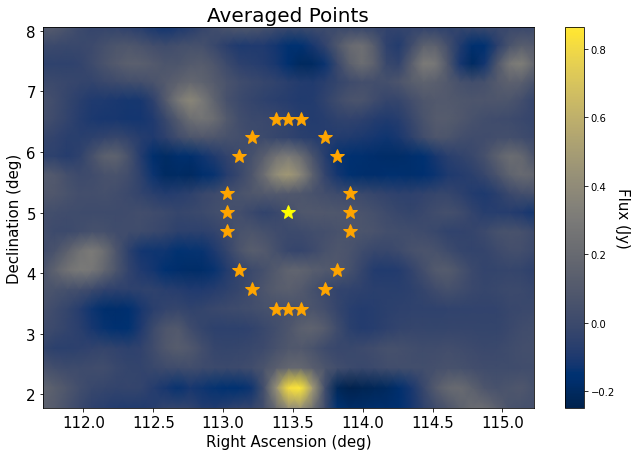

In [16]:
fig = plt.figure(figsize=(11, 7))
plt.title(f"Averaged Points", fontsize=20)
cm = plt.pcolormesh(ra, dec, all_flux_ringmap[1].T, shading='gouraud')
cbar = plt.colorbar(cm)
cbar.set_label('Flux (Jy)', rotation=270, fontsize=15, labelpad=15)
plt.xlabel(r'Right Ascension (deg)', fontsize=15)
plt.ylabel('Declination (deg)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot(ra[20], dec[10], marker='*', markersize=15, color='yellow')

a, b = 20, 10  # Centre pixel
r = 5  # Radius of circle
EPSILON = 2
indexes = list()
for yi in range(len(dec)):
    for xi in range(len(ra)):
        # see if we're close to (x-a)**2 + (y-b)**2 == r**2
        if abs((xi-a)**2 + (yi-b)**2 - r**2) < EPSILON**2:
            plt.plot(ra[xi], dec[yi], marker='*',
                     markersize=15, color='orange')
            indexes.append((xi, yi))
plt.show()

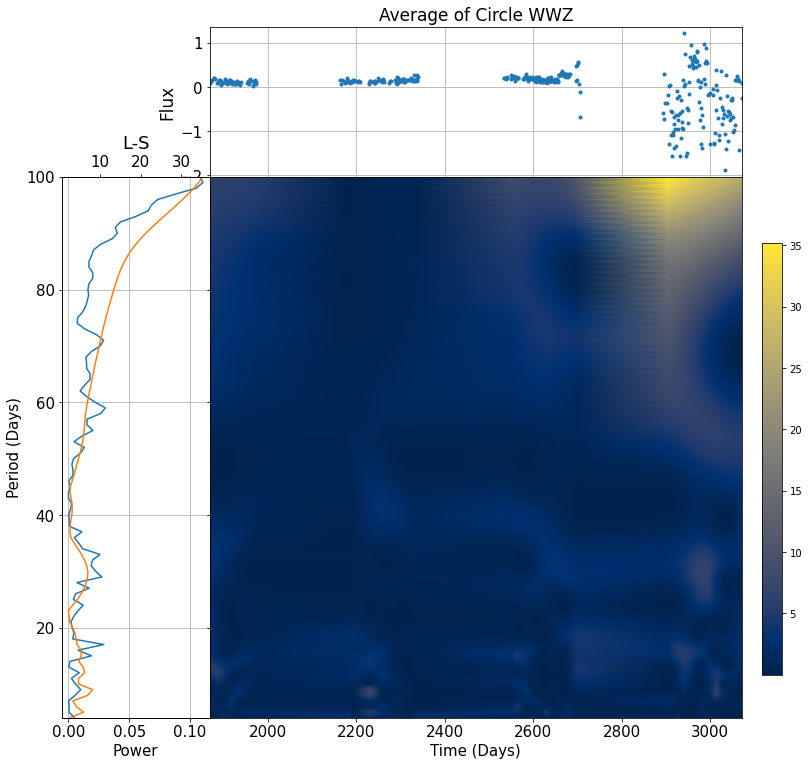

In [17]:
flux_dicts = list()
error_dicts = list()

max_days = list()
for pair in indexes:
    np.zeros(len(days))
    ra_idx, dec_idx = pair
    days, flux, error = remove_outliers_ringmap(ra_idx, dec_idx)
    days, flux, error = fix(days, flux, error)
    flux_dicts.append(dict(zip(days, flux)))
    error_dicts.append(dict(zip(days, error)))
    max_days.append(list(days))

max_days = sorted(set(flatten(max_days)))


dflux = defaultdict(list)
for d in flux_dicts:
    for key, value in d.items():
        dflux[key].append(value)
for key in dflux:
    dflux[key] = np.mean(dflux[key])

derror = defaultdict(list)
for d in error_dicts:
    for key, value in d.items():
        derror[key].append(value)
for key in derror:
    derror[key] = np.mean(derror[key])


avg_flux = list(dflux.values())
avg_error = list(derror.values())
wwz = plot_wwz(np.array(max_days), np.array(avg_flux), np.array(avg_error), period_range=(
    4, 100), title=f"Average of Circle WWZ", c=1/(8*(1.27389**2)*np.pi**2))